In [29]:
import pandas as pd
import numpy as np
import time
from copy import deepcopy

from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn import preprocessing
from recommender import plot_cm, get_results, show_results, IO

from scipy import sparse

import pickle

from IPython.display import display

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
pd.set_option('display.width', 15000)
pd.set_option('display.max_columns', 100)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('poster')
%matplotlib inline

In [3]:
from surprise import Dataset, Reader
from surprise import NormalPredictor, BaselineOnly, SVD, SVDpp, NMF, \
SlopeOne, CoClustering, KNNBasic, KNNWithMeans, KNNBaseline

In [4]:
from recommender import plot_cm, IO
from recommender import ModeClassifier, BaselineMean, BaselineRegression, ALS1, ALS2, RS_surprise

In [5]:
%%time
# Load data

figsize = (7.5, 6)

fig_dir = 'figs/modeling/Champaign/'
data_dir = 'data/Champaign/'

dfb = pd.read_pickle(data_dir + 'business.pkl')
dfr = pd.read_pickle(data_dir + 'review.pkl')
dfu = pd.read_pickle(data_dir + 'user.pkl')
datar = pd.read_pickle(data_dir + 'data_review.pkl')

CPU times: user 46.4 ms, sys: 39.9 ms, total: 86.3 ms
Wall time: 103 ms


In [6]:
df_br = datar.merge(dfb, left_on="business_id", right_on="business_id")
df_br.head()

,user_id,business_id,stars_x,attributes.Ambience.divey,attributes.RestaurantsDelivery,attributes.DogsAllowed,postal_code,hours.Thursday,attributes.BestNights.sunday,attributes.BYOB,attributes.AgesAllowed,attributes.Music.video,hours.Friday,latitude,attributes.Alcohol,attributes.Ambience.classy,attributes.RestaurantsTableService,attributes.Ambience.touristy,attributes.RestaurantsCounterService,attributes.Corkage,attributes.RestaurantsGoodForGroups,categories,name,attributes.BusinessAcceptsBitcoin,attributes.HappyHour,attributes.WheelchairAccessible,attributes.Ambience.hipster,attributes.BusinessAcceptsCreditCards,is_open,attributes.DietaryRestrictions.vegetarian,attributes.Music.live,attributes.Music.background_music,neighborhood,attributes.BusinessParking.lot,attributes.Music.karaoke,review_count,attributes.GoodForMeal.breakfast,attributes.NoiseLevel,state,attributes.DriveThru,attributes.HasTV,attributes.GoodForMeal.dinner,attributes.BusinessParking.street,address,attributes.RestaurantsAttire,hours.Sunday,attributes.BestNights.tuesday,attributes.AcceptsInsurance,attributes.BestNights.wednesday,hours.Wednesday,attributes.Open24Hours,attributes.Ambience.trendy,attributes.CoatCheck,hours.Monday,city,attributes.Music.no_music,hours.Tuesday,stars_y,attributes.RestaurantsPriceRange2,attributes.Ambience.intimate,attributes.GoodForMeal.latenight,attributes.GoodForMeal.dessert,attributes.BusinessParking.validated,attributes.GoodForMeal.lunch,attributes.GoodForKids,attributes.DietaryRestrictions.soy-free,attributes.GoodForMeal.brunch,attributes.BusinessParking.valet,longitude,attributes.DietaryRestrictions.gluten-free,attributes.BYOBCorkage,attributes.BusinessParking.garage,attributes.BestNights.friday,hours.Saturday,attributes.Music.dj,attributes.BestNights.saturday,attributes.Ambience.casual,attributes.BestNights.thursday,attributes.BestNights.monday,attributes.DietaryRestrictions.kosher,attributes.WiFi,attributes.Smoking,attributes.DietaryRestrictions.halal,attributes.GoodForDancing,attributes.ByAppointmentOnly,attributes.Caters,attributes.RestaurantsReservations,attributes.DietaryRestrictions.dairy-free,attributes.DietaryRestrictions.vegan,attributes.Ambience.romantic,attributes.Music.jukebox,attributes.Ambience.upscale,attributes.RestaurantsTakeOut,attributes.BikeParking,attributes.OutdoorSeating
0,1305,44,4,NaN,NaN,NaN,61820,NaN,NaN,NaN,NaN,NaN,NaN,40.112407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[u'Property Management', u'Real Estate', u'Apa...",Professional Property Management,NaN,NaN,NaN,NaN,False,1,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,IL,NaN,NaN,NaN,NaN,401 E Springfield Ave,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Champaign,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-88.233285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1306,44,1,NaN,NaN,NaN,61820,NaN,NaN,NaN,NaN,NaN,NaN,40.112407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[u'Property Management', u'Real Estate', u'Apa...",Professional Property Management,NaN,NaN,NaN,NaN,False,1,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,IL,NaN,NaN,NaN,NaN,401 E Springfield Ave,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Champaign,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-88.233285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1307,44,1,NaN,NaN,NaN,61820,NaN,NaN,NaN,NaN,NaN,NaN,40.112407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[u'Property Management', u'Real Estate', u'Apa...",Professional Property Management,NaN,NaN,NaN,NaN,False,1,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,IL,NaN,NaN,NaN,NaN,401 E Springfield Ave,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Champaign,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-88.233285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1308,44,1,NaN,NaN,NaN,61820,NaN,NaN,NaN,NaN,NaN,NaN,40.112407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[u'Property Management', u'Real Estate', u'Apa...",Professional Property Management,Na

In [7]:
df_ubr = df_br.merge(dfu, left_on="user_id", right_on="user_id")
df_ubr.head()

,user_id,business_id,stars_x,attributes.Ambience.divey,attributes.RestaurantsDelivery,attributes.DogsAllowed,postal_code,hours.Thursday,attributes.BestNights.sunday,attributes.BYOB,attributes.AgesAllowed,attributes.Music.video,hours.Friday,latitude,attributes.Alcohol,attributes.Ambience.classy,attributes.RestaurantsTableService,attributes.Ambience.touristy,attributes.RestaurantsCounterService,attributes.Corkage,attributes.RestaurantsGoodForGroups,categories,name_x,attributes.BusinessAcceptsBitcoin,attributes.HappyHour,attributes.WheelchairAccessible,attributes.Ambience.hipster,attributes.BusinessAcceptsCreditCards,is_open,attributes.DietaryRestrictions.vegetarian,attributes.Music.live,attributes.Music.background_music,neighborhood,attributes.BusinessParking.lot,attributes.Music.karaoke,review_count_x,attributes.GoodForMeal.breakfast,attributes.NoiseLevel,state,attributes.DriveThru,attributes.HasTV,attributes.GoodForMeal.dinner,attributes.BusinessParking.street,address,attributes.RestaurantsAttire,hours.Sunday,attributes.BestNights.tuesday,attributes.AcceptsInsurance,attributes.BestNights.wednesday,hours.Wednesday,...,attributes.GoodForMeal.brunch,attributes.BusinessParking.valet,longitude,attributes.DietaryRestrictions.gluten-free,attributes.BYOBCorkage,attributes.BusinessParking.garage,attributes.BestNights.friday,hours.Saturday,attributes.Music.dj,attributes.BestNights.saturday,attributes.Ambience.casual,attributes.BestNights.thursday,attributes.BestNights.monday,attributes.DietaryRestrictions.kosher,attributes.WiFi,attributes.Smoking,attributes.DietaryRestrictions.halal,attributes.GoodForDancing,attributes.ByAppointmentOnly,attributes.Caters,attributes.RestaurantsReservations,attributes.DietaryRestrictions.dairy-free,attributes.DietaryRestrictions.vegan,attributes.Ambience.romantic,attributes.Music.jukebox,attributes.Ambience.upscale,attributes.RestaurantsTakeOut,attributes.BikeParking,attributes.OutdoorSeating,yelping_since,useful,compliment_photos,compliment_list,compliment_funny,compliment_plain,review_count_y,elite,fans,compliment_note,funny,compliment_writer,compliment_cute,average_stars,compliment_more,friends,compliment_hot,cool,name_y,compliment_profile,compliment_cool
0,1305,44,4,NaN,NaN,NaN,61820,NaN,NaN,NaN,NaN,NaN,NaN,40.112407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[u'Property Management', u'Real Estate', u'Apa...",Professional Property Management,NaN,NaN,NaN,NaN,False,1,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,IL,NaN,NaN,NaN,NaN,401 E Springfield Ave,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-88.233285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-08-13,63,0,0,0,1,189,[],3,0,11,0,0,3.84,0,"[u'Azi0eHGZaVIZCgDuCzRlGw', u'7bmSgEJk3B4Bkt0E...",0,4,Francisco,0,0
1,1305,25959,5,False,False,NaN,61820,11:00-21:00,NaN,NaN,NaN,NaN,11:00-21:00,40.110409,none,False,False,False,NaN,NaN,False,"[u'Restaurants', u'Mexican']",Maize Mexican Grill,NaN,NaN,NaN,False,True,1,NaN,NaN,NaN,NaN,True,NaN,448,False,loud,IL,NaN,False,True,False,60 E Green St,casual,11:00-21:00,NaN,NaN,NaN,11:00-21:00,...,False,False,-88.238955,NaN,NaN,False,NaN,11:00-21:00,NaN,NaN,True,NaN,NaN,NaN,no,NaN,NaN,NaN,NaN,True,False,NaN,NaN,False,NaN,False,True,True,False,2014-08-13,63,0,0,0,1,189,[],3,0,11,0,0,3.84,0,"[u'Azi0eHGZaVIZCgDuCzRlGw', u'7bmSgEJk3B4Bkt0E...",0,4,Francisco,0,0
2,1305,59088,4,False,False,NaN,61820,17:00-21:30,NaN,False,NaN,NaN,16:30-22:30,40.118531,beer_and_wine,False,True,False,NaN,NaN,True,"[u'Sushi Bars', u'Restaurants', u'Japanese']",Sushi Kame,NaN,NaN,True,False,True,1,NaN,NaN,NaN,NaN,False,NaN,131,False,quiet,IL,NaN,False,True,True,132 W Church St,casual,12:00-21:00,NaN,NaN,NaN,17:00-21:30,...,False,False,-88.244803,NaN,no,False,NaN,12:00-22:30,NaN,NaN,True,NaN,NaN,NaN,no,NaN,NaN,NaN,NaN,False,True,NaN,NaN,False,NaN,False,True,True,False,2014-08-13,63,0,0,0,1,189,[],3,0,11,0,0,3.84,0,"[u'Azi0eHGZaVIZCgDuCzRlGw', u'7bmSgEJk3B4Bkt0E...",0,4,Francisco,0,0
3,1305,68537,1,NaN,NaN,NaN,61820,Na

In [8]:
y = df_ubr['stars_x'].values

In [9]:
col_dummy = ['attributes.Alcohol', 'attributes.AgesAllowed', 'attributes.NoiseLevel', \
             'attributes.WiFi', 'attributes.Smoking', 'attributes.RestaurantsAttire']

In [10]:
col_boolean = ['attributes.RestaurantsDelivery', 'attributes.DogsAllowed', 'attributes.BYOB', \
              'attributes.RestaurantsTableService', 'attributes.RestaurantsCounterService', \
              'attributes.Corkage', 'attributes.BusinessAcceptsBitcoin', 'attributes.WheelchairAccessible', \
              'attributes.BusinessAcceptsCreditCards', 'attributes.BusinessParking.lot', 'attributes.DriveThru', \
              'attributes.HasTV', 'attributes.BusinessParking.street', 'attributes.AcceptsInsurance', \
              'attributes.BusinessParking.valet', 'attributes.BYOBCorkage', 'attributes.BusinessParking.garage', \
              'attributes.ByAppointmentOnly', 'attributes.Caters', 'attributes.RestaurantsReservations', \
              'attributes.RestaurantsTakeOut', 'attributes.BikeParking', 'attributes.OutdoorSeating',\
              'attributes.BusinessParking.validated']

In [11]:
df_ubr = df_ubr.fillna(0)
df_ubr.head()

,user_id,business_id,stars_x,attributes.Ambience.divey,attributes.RestaurantsDelivery,attributes.DogsAllowed,postal_code,hours.Thursday,attributes.BestNights.sunday,attributes.BYOB,attributes.AgesAllowed,attributes.Music.video,hours.Friday,latitude,attributes.Alcohol,attributes.Ambience.classy,attributes.RestaurantsTableService,attributes.Ambience.touristy,attributes.RestaurantsCounterService,attributes.Corkage,attributes.RestaurantsGoodForGroups,categories,name_x,attributes.BusinessAcceptsBitcoin,attributes.HappyHour,attributes.WheelchairAccessible,attributes.Ambience.hipster,attributes.BusinessAcceptsCreditCards,is_open,attributes.DietaryRestrictions.vegetarian,attributes.Music.live,attributes.Music.background_music,neighborhood,attributes.BusinessParking.lot,attributes.Music.karaoke,review_count_x,attributes.GoodForMeal.breakfast,attributes.NoiseLevel,state,attributes.DriveThru,attributes.HasTV,attributes.GoodForMeal.dinner,attributes.BusinessParking.street,address,attributes.RestaurantsAttire,hours.Sunday,attributes.BestNights.tuesday,attributes.AcceptsInsurance,attributes.BestNights.wednesday,hours.Wednesday,...,attributes.GoodForMeal.brunch,attributes.BusinessParking.valet,longitude,attributes.DietaryRestrictions.gluten-free,attributes.BYOBCorkage,attributes.BusinessParking.garage,attributes.BestNights.friday,hours.Saturday,attributes.Music.dj,attributes.BestNights.saturday,attributes.Ambience.casual,attributes.BestNights.thursday,attributes.BestNights.monday,attributes.DietaryRestrictions.kosher,attributes.WiFi,attributes.Smoking,attributes.DietaryRestrictions.halal,attributes.GoodForDancing,attributes.ByAppointmentOnly,attributes.Caters,attributes.RestaurantsReservations,attributes.DietaryRestrictions.dairy-free,attributes.DietaryRestrictions.vegan,attributes.Ambience.romantic,attributes.Music.jukebox,attributes.Ambience.upscale,attributes.RestaurantsTakeOut,attributes.BikeParking,attributes.OutdoorSeating,yelping_since,useful,compliment_photos,compliment_list,compliment_funny,compliment_plain,review_count_y,elite,fans,compliment_note,funny,compliment_writer,compliment_cute,average_stars,compliment_more,friends,compliment_hot,cool,name_y,compliment_profile,compliment_cool
0,1305,44,4,0,0,0,61820,0,0,0,0,0,0,40.112407,0,0,0,0,0,0,0,"[u'Property Management', u'Real Estate', u'Apa...",Professional Property Management,0,0,0,0,False,1,0,0,0,0,0,0,10,0,0,IL,0,0,0,0,401 E Springfield Ave,0,0,0,0,0,0,...,0,0,-88.233285,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,2014-08-13,63,0,0,0,1,189,[],3,0,11,0,0,3.84,0,"[u'Azi0eHGZaVIZCgDuCzRlGw', u'7bmSgEJk3B4Bkt0E...",0,4,Francisco,0,0
1,1305,25959,5,False,False,0,61820,11:00-21:00,0,0,0,0,11:00-21:00,40.110409,none,False,False,False,0,0,False,"[u'Restaurants', u'Mexican']",Maize Mexican Grill,0,0,0,False,True,1,0,0,0,0,True,0,448,False,loud,IL,0,False,True,False,60 E Green St,casual,11:00-21:00,0,0,0,11:00-21:00,...,False,False,-88.238955,0,0,False,0,11:00-21:00,0,0,True,0,0,0,no,0,0,0,0,True,False,0,0,False,0,False,True,True,False,2014-08-13,63,0,0,0,1,189,[],3,0,11,0,0,3.84,0,"[u'Azi0eHGZaVIZCgDuCzRlGw', u'7bmSgEJk3B4Bkt0E...",0,4,Francisco,0,0
2,1305,59088,4,False,False,0,61820,17:00-21:30,0,False,0,0,16:30-22:30,40.118531,beer_and_wine,False,True,False,0,0,True,"[u'Sushi Bars', u'Restaurants', u'Japanese']",Sushi Kame,0,0,True,False,True,1,0,0,0,0,False,0,131,False,quiet,IL,0,False,True,True,132 W Church St,casual,12:00-21:00,0,0,0,17:00-21:30,...,False,False,-88.244803,0,no,False,0,12:00-22:30,0,0,True,0,0,0,no,0,0,0,0,False,True,0,0,False,0,False,True,True,False,2014-08-13,63,0,0,0,1,189,[],3,0,11,0,0,3.84,0,"[u'Azi0eHGZaVIZCgDuCzRlGw', u'7bmSgEJk3B4Bkt0E...",0,4,Francisco,0,0
3,1305,68537,1,0,0,0,61820,0,0,0,0,0,0,40.108412,0,0,0,0,0,0,0,"[u'General Dentistry', u'Health & Medical', u'...",Champaign Dental Group,0,0,0,0,True,1,0,0,0,0,0,0,37,0,0,IL,0,0,0,0,703 S Neil St,0,0,0,True,0,0,...,0,0,-88.243987,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,0,0,0,0,0,0,0,0,0,0,2014-08-1

In [12]:
col_drop = ['user_id', 'business_id', 'stars_x', 'postal_code', 'latitude', 'categories', 'name_x', \
'neighborhood', 'review_count_x', 'state', 'address', 'hours.Sunday', 'hours.Monday','hours.Tuesday','hours.Wednesday','hours.Thursday','hours.Friday','hours.Saturday',\
'longitude', 'elite', 'friends', 'name_y', 'city']

## uncertain: neighborhood, state

df_ubr = df_ubr.drop(col_drop, 1)
df_ubr.head()

,attributes.Ambience.divey,attributes.RestaurantsDelivery,attributes.DogsAllowed,attributes.BestNights.sunday,attributes.BYOB,attributes.AgesAllowed,attributes.Music.video,attributes.Alcohol,attributes.Ambience.classy,attributes.RestaurantsTableService,attributes.Ambience.touristy,attributes.RestaurantsCounterService,attributes.Corkage,attributes.RestaurantsGoodForGroups,attributes.BusinessAcceptsBitcoin,attributes.HappyHour,attributes.WheelchairAccessible,attributes.Ambience.hipster,attributes.BusinessAcceptsCreditCards,is_open,attributes.DietaryRestrictions.vegetarian,attributes.Music.live,attributes.Music.background_music,attributes.BusinessParking.lot,attributes.Music.karaoke,attributes.GoodForMeal.breakfast,attributes.NoiseLevel,attributes.DriveThru,attributes.HasTV,attributes.GoodForMeal.dinner,attributes.BusinessParking.street,attributes.RestaurantsAttire,attributes.BestNights.tuesday,attributes.AcceptsInsurance,attributes.BestNights.wednesday,attributes.Open24Hours,attributes.Ambience.trendy,attributes.CoatCheck,attributes.Music.no_music,stars_y,attributes.RestaurantsPriceRange2,attributes.Ambience.intimate,attributes.GoodForMeal.latenight,attributes.GoodForMeal.dessert,attributes.BusinessParking.validated,attributes.GoodForMeal.lunch,attributes.GoodForKids,attributes.DietaryRestrictions.soy-free,attributes.GoodForMeal.brunch,attributes.BusinessParking.valet,attributes.DietaryRestrictions.gluten-free,attributes.BYOBCorkage,attributes.BusinessParking.garage,attributes.BestNights.friday,attributes.Music.dj,attributes.BestNights.saturday,attributes.Ambience.casual,attributes.BestNights.thursday,attributes.BestNights.monday,attributes.DietaryRestrictions.kosher,attributes.WiFi,attributes.Smoking,attributes.DietaryRestrictions.halal,attributes.GoodForDancing,attributes.ByAppointmentOnly,attributes.Caters,attributes.RestaurantsReservations,attributes.DietaryRestrictions.dairy-free,attributes.DietaryRestrictions.vegan,attributes.Ambience.romantic,attributes.Music.jukebox,attributes.Ambience.upscale,attributes.RestaurantsTakeOut,attributes.BikeParking,attributes.OutdoorSeating,yelping_since,useful,compliment_photos,compliment_list,compliment_funny,compliment_plain,review_count_y,fans,compliment_note,funny,compliment_writer,compliment_cute,average_stars,compliment_more,compliment_hot,cool,compliment_profile,compliment_cool
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.5,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,2014-08-13,63,0,0,0,1,189,3,0,11,0,0,3.84,0,0,4,0,0
1,False,False,0,0,0,0,0,none,False,False,False,0,0,False,0,0,0,False,True,1,0,0,0,True,0,False,loud,0,False,True,False,casual,0,0,0,0,False,0,0,4.5,1.0,False,False,False,False,True,True,0,False,False,0,0,False,0,0,0,True,0,0,0,no,0,0,0,0,True,False,0,0,False,0,False,True,True,False,2014-08-13,63,0,0,0,1,189,3,0,11,0,0,3.84,0,0,4,0,0
2,False,False,0,0,False,0,0,beer_and_wine,False,True,False,0,0,True,0,0,True,False,True,1,0,0,0,False,0,False,quiet,0,False,True,True,casual,0,0,0,0,False,0,0,3.5,2.0,False,False,False,False,True,True,0,False,False,0,no,False,0,0,0,True,0,0,0,no,0,0,0,0,False,True,0,0,False,0,False,True,True,False,2014-08-13,63,0,0,0,1,189,3,0,11,0,0,3.84,0,0,4,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,True,0,0,0,0,0,2.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,0,0,0,0,0,0,0,0,0,0,2014-08-13,63,0,0,0,1,189,3,0,11,0,0,3.84,0,0,4,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.5,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2014-08-13,63,0,0,0,1,189,3,0,11,0,0,3.84,0,0,4,0,0


In [14]:
df_ubr = pd.get_dummies(df_ubr, columns=col_dummy, drop_first=True)
df_ubr.head()

,attributes.Ambience.divey,attributes.RestaurantsDelivery,attributes.DogsAllowed,attributes.BestNights.sunday,attributes.BYOB,attributes.Music.video,attributes.Ambience.classy,attributes.RestaurantsTableService,attributes.Ambience.touristy,attributes.RestaurantsCounterService,attributes.Corkage,attributes.RestaurantsGoodForGroups,attributes.BusinessAcceptsBitcoin,attributes.HappyHour,attributes.WheelchairAccessible,attributes.Ambience.hipster,attributes.BusinessAcceptsCreditCards,is_open,attributes.DietaryRestrictions.vegetarian,attributes.Music.live,attributes.Music.background_music,attributes.BusinessParking.lot,attributes.Music.karaoke,attributes.GoodForMeal.breakfast,attributes.DriveThru,attributes.HasTV,attributes.GoodForMeal.dinner,attributes.BusinessParking.street,attributes.BestNights.tuesday,attributes.AcceptsInsurance,attributes.BestNights.wednesday,attributes.Open24Hours,attributes.Ambience.trendy,attributes.CoatCheck,attributes.Music.no_music,stars_y,attributes.RestaurantsPriceRange2,attributes.Ambience.intimate,attributes.GoodForMeal.latenight,attributes.GoodForMeal.dessert,attributes.BusinessParking.validated,attributes.GoodForMeal.lunch,attributes.GoodForKids,attributes.DietaryRestrictions.soy-free,attributes.GoodForMeal.brunch,attributes.BusinessParking.valet,attributes.DietaryRestrictions.gluten-free,attributes.BYOBCorkage,attributes.BusinessParking.garage,attributes.BestNights.friday,...,attributes.DietaryRestrictions.kosher,attributes.DietaryRestrictions.halal,attributes.GoodForDancing,attributes.ByAppointmentOnly,attributes.Caters,attributes.RestaurantsReservations,attributes.DietaryRestrictions.dairy-free,attributes.DietaryRestrictions.vegan,attributes.Ambience.romantic,attributes.Music.jukebox,attributes.Ambience.upscale,attributes.RestaurantsTakeOut,attributes.BikeParking,attributes.OutdoorSeating,yelping_since,useful,compliment_photos,compliment_list,compliment_funny,compliment_plain,review_count_y,fans,compliment_note,funny,compliment_writer,compliment_cute,average_stars,compliment_more,compliment_hot,cool,compliment_profile,compliment_cool,attributes.Alcohol_beer_and_wine,attributes.Alcohol_full_bar,attributes.Alcohol_none,attributes.AgesAllowed_18plus,attributes.AgesAllowed_21plus,attributes.NoiseLevel_average,attributes.NoiseLevel_loud,attributes.NoiseLevel_quiet,attributes.NoiseLevel_very_loud,attributes.WiFi_free,attributes.WiFi_no,attributes.WiFi_paid,attributes.Smoking_no,attributes.Smoking_outdoor,attributes.Smoking_yes,attributes.RestaurantsAttire_casual,attributes.RestaurantsAttire_dressy,attributes.RestaurantsAttire_formal
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.5,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,False,0,0,0,0,0,0,0,0,0,0,2014-08-13,63,0,0,0,1,189,3,0,11,0,0,3.84,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,False,False,0,0,0,0,False,False,False,0,0,False,0,0,0,False,True,1,0,0,0,True,0,False,0,False,True,False,0,0,0,0,False,0,0,4.5,1.0,False,False,False,False,True,True,0,False,False,0,0,False,0,...,0,0,0,0,True,False,0,0,False,0,False,True,True,False,2014-08-13,63,0,0,0,1,189,3,0,11,0,0,3.84,0,0,4,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
2,False,False,0,0,False,0,False,True,False,0,0,True,0,0,True,False,True,1,0,0,0,False,0,False,0,False,True,True,0,0,0,0,False,0,0,3.5,2.0,False,False,False,False,True,True,0,False,False,0,no,False,0,...,0,0,0,0,False,True,0,0,False,0,False,True,True,False,2014-08-13,63,0,0,0,1,189,3,0,11,0,0,3.84,0,0,4,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,1,0,0,0,0,0,0,0,0,0,0,0,True,0,0,0,0,0,2.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,True,0,0,0,0,0,0,0,0,0,0,2014-08-13,63,0,0,0,1,189,3,0,11,0,0,3.84,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.5,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2014-08-13,63,0,0,0,1,189,3,0,11,0,0,3.84,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
def alter_boolean(df_ubr, col_boolean):
    for column in col_boolean:
        df_ubr[column] = df_ubr[column].apply(lambda x: 1 if x == True else 0)

In [16]:
alter_boolean(df_ubr, col_boolean)
df_ubr.head()

,attributes.Ambience.divey,attributes.RestaurantsDelivery,attributes.DogsAllowed,attributes.BestNights.sunday,attributes.BYOB,attributes.Music.video,attributes.Ambience.classy,attributes.RestaurantsTableService,attributes.Ambience.touristy,attributes.RestaurantsCounterService,attributes.Corkage,attributes.RestaurantsGoodForGroups,attributes.BusinessAcceptsBitcoin,attributes.HappyHour,attributes.WheelchairAccessible,attributes.Ambience.hipster,attributes.BusinessAcceptsCreditCards,is_open,attributes.DietaryRestrictions.vegetarian,attributes.Music.live,attributes.Music.background_music,attributes.BusinessParking.lot,attributes.Music.karaoke,attributes.GoodForMeal.breakfast,attributes.DriveThru,attributes.HasTV,attributes.GoodForMeal.dinner,attributes.BusinessParking.street,attributes.BestNights.tuesday,attributes.AcceptsInsurance,attributes.BestNights.wednesday,attributes.Open24Hours,attributes.Ambience.trendy,attributes.CoatCheck,attributes.Music.no_music,stars_y,attributes.RestaurantsPriceRange2,attributes.Ambience.intimate,attributes.GoodForMeal.latenight,attributes.GoodForMeal.dessert,attributes.BusinessParking.validated,attributes.GoodForMeal.lunch,attributes.GoodForKids,attributes.DietaryRestrictions.soy-free,attributes.GoodForMeal.brunch,attributes.BusinessParking.valet,attributes.DietaryRestrictions.gluten-free,attributes.BYOBCorkage,attributes.BusinessParking.garage,attributes.BestNights.friday,...,attributes.DietaryRestrictions.kosher,attributes.DietaryRestrictions.halal,attributes.GoodForDancing,attributes.ByAppointmentOnly,attributes.Caters,attributes.RestaurantsReservations,attributes.DietaryRestrictions.dairy-free,attributes.DietaryRestrictions.vegan,attributes.Ambience.romantic,attributes.Music.jukebox,attributes.Ambience.upscale,attributes.RestaurantsTakeOut,attributes.BikeParking,attributes.OutdoorSeating,yelping_since,useful,compliment_photos,compliment_list,compliment_funny,compliment_plain,review_count_y,fans,compliment_note,funny,compliment_writer,compliment_cute,average_stars,compliment_more,compliment_hot,cool,compliment_profile,compliment_cool,attributes.Alcohol_beer_and_wine,attributes.Alcohol_full_bar,attributes.Alcohol_none,attributes.AgesAllowed_18plus,attributes.AgesAllowed_21plus,attributes.NoiseLevel_average,attributes.NoiseLevel_loud,attributes.NoiseLevel_quiet,attributes.NoiseLevel_very_loud,attributes.WiFi_free,attributes.WiFi_no,attributes.WiFi_paid,attributes.Smoking_no,attributes.Smoking_outdoor,attributes.Smoking_yes,attributes.RestaurantsAttire_casual,attributes.RestaurantsAttire_dressy,attributes.RestaurantsAttire_formal
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.5,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2014-08-13,63,0,0,0,1,189,3,0,11,0,0,3.84,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,False,0,0,0,0,0,False,0,False,0,0,False,0,0,0,False,1,1,0,0,0,1,0,False,0,0,True,0,0,0,0,0,False,0,0,4.5,1.0,False,False,False,0,True,True,0,False,0,0,0,0,0,...,0,0,0,0,1,0,0,0,False,0,False,1,1,0,2014-08-13,63,0,0,0,1,189,3,0,11,0,0,3.84,0,0,4,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
2,False,0,0,0,0,0,False,1,False,0,0,True,0,0,1,False,1,1,0,0,0,0,0,False,0,0,True,1,0,0,0,0,False,0,0,3.5,2.0,False,False,False,0,True,True,0,False,0,0,0,0,0,...,0,0,0,0,0,1,0,0,False,0,False,1,1,0,2014-08-13,63,0,0,0,1,189,3,0,11,0,0,3.84,0,0,4,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2014-08-13,63,0,0,0,1,189,3,0,11,0,0,3.84,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.5,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2014-08-13,63,0,0,0,1,189,3,0,11,0,0,3.84,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
#df_all = pd.DataFrame()
df_ubr['yelping_since'] = df_ubr['yelping_since'].apply(lambda x: int(x[0:4]) - 2005)
df_ubr['stars_y'] = df_ubr['stars_y'].apply(lambda x: x)
df_ubr['attributes.Ambience.divey'] = df_ubr['attributes.Ambience.divey'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.Ambience.casual'] = df_ubr['attributes.Ambience.casual'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.Ambience.classy'] = df_ubr['attributes.Ambience.classy'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.Ambience.hipster'] = df_ubr['attributes.Ambience.hipster'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.Ambience.intimate'] = df_ubr['attributes.Ambience.intimate'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.Ambience.romantic'] = df_ubr['attributes.Ambience.romantic'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.Ambience.touristy'] = df_ubr['attributes.Ambience.touristy'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.Ambience.trendy'] = df_ubr['attributes.Ambience.trendy'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.Ambience.upscale'] = df_ubr['attributes.Ambience.upscale'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.BestNights.friday'] = df_ubr['attributes.BestNights.friday'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.BestNights.monday'] = df_ubr['attributes.BestNights.monday'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.BestNights.thursday'] = df_ubr['attributes.BestNights.thursday'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.BestNights.tuesday'] = df_ubr['attributes.BestNights.tuesday'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.BestNights.wednesday'] = df_ubr['attributes.BestNights.wednesday'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.BestNights.saturday'] = df_ubr['attributes.BestNights.saturday'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.BestNights.sunday'] = df_ubr['attributes.BestNights.sunday'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.DietaryRestrictions.dairy-free'] = df_ubr['attributes.DietaryRestrictions.dairy-free'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.DietaryRestrictions.halal'] = df_ubr['attributes.DietaryRestrictions.halal'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.DietaryRestrictions.kosher'] = df_ubr['attributes.DietaryRestrictions.kosher'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.DietaryRestrictions.soy-free'] = df_ubr['attributes.DietaryRestrictions.soy-free'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.DietaryRestrictions.vegan'] = df_ubr['attributes.DietaryRestrictions.vegan'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.DietaryRestrictions.vegetarian'] = df_ubr['attributes.DietaryRestrictions.vegetarian'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.GoodForDancing'] = df_ubr['attributes.GoodForDancing'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.GoodForKids'] = df_ubr['attributes.GoodForKids'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.GoodForMeal.lunch'] = df_ubr['attributes.GoodForMeal.lunch'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.GoodForMeal.brunch'] = df_ubr['attributes.GoodForMeal.brunch'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.GoodForMeal.dinner'] = df_ubr['attributes.GoodForMeal.dinner'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.GoodForMeal.latenight'] = df_ubr['attributes.GoodForMeal.latenight'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.RestaurantsGoodForGroups'] = df_ubr['attributes.RestaurantsGoodForGroups'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.Music.background_music'] = df_ubr['attributes.Music.background_music'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.Music.dj'] = df_ubr['attributes.Music.dj'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.Music.jukebox'] = df_ubr['attributes.Music.jukebox'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.Music.karaoke'] = df_ubr['attributes.Music.karaoke'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.Music.live'] = df_ubr['attributes.Music.live'].apply(lambda x: 1 if x == True else 0)
df_ubr['attributes.Music.video'] = df_ubr['attributes.Music.video'].apply(lambda x: 1 if x == True else 0)


In [18]:
np.random.seed(6006)
msk = np.random.rand(len(df_ubr)) < 0.5 
X = df_ubr.iloc[:,:].values
X_train = X[msk]
y_train = y[msk]
X_test = X[~msk]
y_test = y[~msk]

In [20]:
std_scale = preprocessing.StandardScaler().fit(X_train)

X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

/Users/gwungwun/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [21]:
clf_ridge = RidgeCV(fit_intercept=True, normalize=True)
clf_ridge.fit(X_train, y_train)
print('Ridge Train Score', clf_ridge.score(X_train, y_train)) 
print('Ridge Test Score', clf_ridge.score(X_test, y_test))

Ridge Train Score 0.427613818268
Ridge Test Score 0.427580473976


In [24]:
import sklearn
from sklearn.metrics import mean_squared_error
sklearn.metrics.mean_squared_error(clf_ridge.predict(X_test), y_test)

1.1848607172113748

Ridge regression
RMSE on training set: 1.0891100979100514.
RMSE on test set: 1.0885130762702737.
r2 on training set: 0.4276138182683259.
r2 on test set: 0.42758047397581833.
Classification accuracy on training set: 0.36662093296746373.
Classification accuracy on test set: 0.36654769943088644.


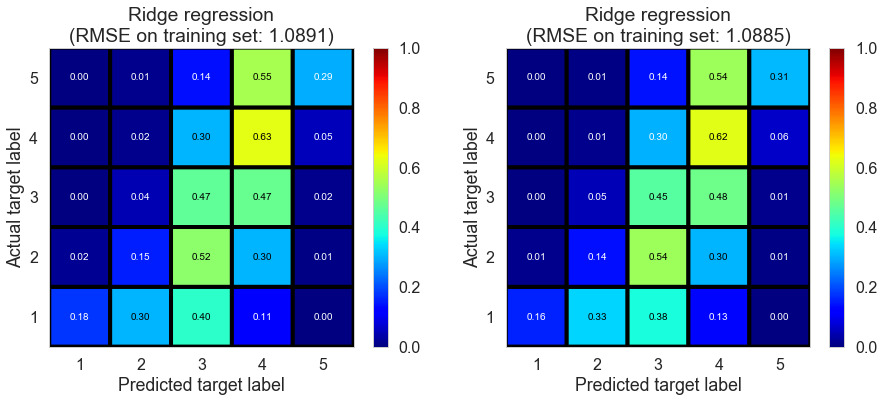

In [39]:
show_results(clf_ridge, "Ridge regression", X_train, y_train, X_test, y_test)

In [25]:
clf_lasso = LassoCV(fit_intercept=True, normalize=True)
clf_lasso.fit(X_train, y_train)
print('Lasso Train Score', clf_lasso.score(X_train, y_train))
print('Lasso Test Score', clf_lasso.score(X_test, y_test))
sklearn.metrics.mean_squared_error(clf_lasso.predict(X_test), y_test)

Lasso Train Score 0.424826358127
Lasso Test Score 0.430592284695


1.1786265200070474

Lasso regression
RMSE on training set: 1.0917588025684686.
RMSE on test set: 1.0856456696395225.
r2 on training set: 0.42482635812669334.
r2 on test set: 0.43059228469500666.
Classification accuracy on training set: 0.37740101920815367.
Classification accuracy on test set: 0.38217420661715057.


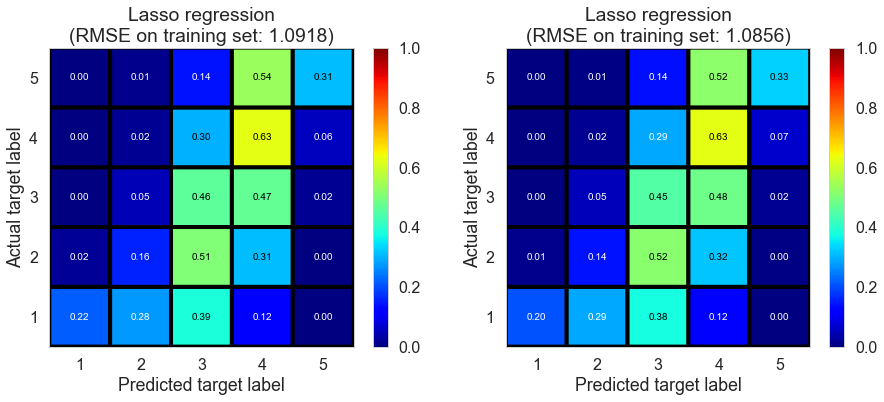

In [40]:
show_results(clf_lasso, "Lasso regression", X_train, y_train, X_test, y_test)

In [27]:
logregcv = LogisticRegressionCV(random_state = 123) 
logregcv.fit(X_train, y_train)
y_hat_train = logregcv.predict(X_train)
y_hat_test = logregcv.predict(X_test)
print("Train accuracy: ", accuracy_score(y_train, y_hat_train))
print("Test accuracy: ", accuracy_score(y_test, y_hat_test))

Train accuracy:  0.490101920815
Test accuracy:  0.483264203723


logistic regression
RMSE on training set: 1.4345105306562587.
RMSE on test set: 1.4330834504462382.
r2 on training set: 0.006991301749271428.
r2 on test set: 0.007820841742010587.
Classification accuracy on training set: 0.4901019208153665.
Classification accuracy on test set: 0.48326420372335294.


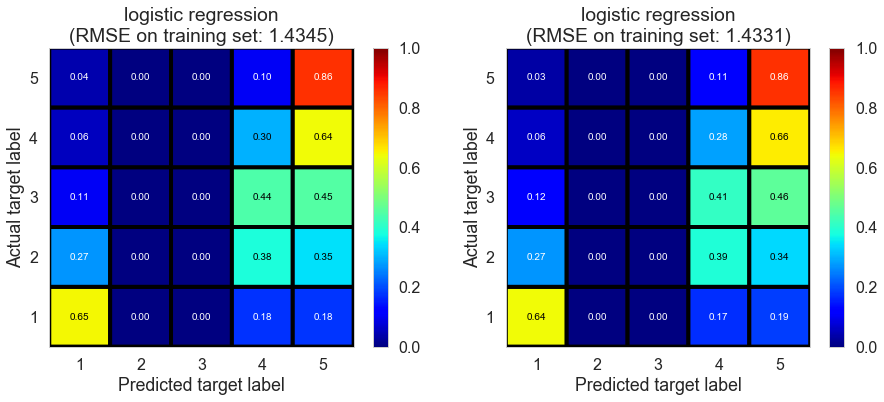

In [38]:
show_results(logregcv, "logistic regression", X_train, y_train, X_test, y_test, )

In [37]:
def get_results(es, X_train, y_train, X_test, y_test, X_cv=None, y_cv=None, save2=None):
    s_train = get_single_result(es, X_train, y_train)
    s_test = get_single_result(es, X_test, y_test)
    scores = [s_train[1], s_test[1], s_train[2], s_test[2], s_train[3], s_test[3]]
    y_preds = [s_train[0], s_test[0]]
    if X_cv is not None:
        s_cv = get_single_result(es, X_cv, y_cv)
        y_preds.append(s_cv[0])
    results = [y_preds, scores]
    if save2 is not None:
        IO(save2).to_pickle(results)
    return results
        
def show_results(es, model_name, X_train, y_train, X_test, y_test, results=None, \
                  print_=True, plot=True, figname=None):
    print(model_name)
    if results is None:
        results = get_results(es, X_train, y_train, X_test, y_test)
    y_preds, scores = results
    if print_:
        print('RMSE on training set: {}.'.format(scores[0]))
        print('RMSE on test set: {}.'.format(scores[1]))
        print('r2 on training set: {}.'.format(scores[2]))

        print('r2 on test set: {}.'.format(scores[3]))
        print('Classification accuracy on training set: {}.'.format(scores[4]))
        print('Classification accuracy on test set: {}.'.format(scores[5]))
    if plot:
        plt.figure(figsize=(15, 5.5))
        plt.subplot(1, 2, 1)
        plot_cm(confusion_matrix(y_train, y_preds[0][1]), \
        model_name + '\n(RMSE on training set: {:.4f})'.format(scores[0]))
        plt.subplot(1, 2, 2)
        plot_cm(confusion_matrix(y_test, y_preds[1][1]), \
        model_name + '\n(RMSE on training set: {:.4f})'.format(scores[1]))
        if figname is not None:
            plt.savefig(figname, bbox_inches='tight');
        plt.show();
    print()
    
def get_single_result(es, X, y):
    y_pred = get_predictions(es, X)
    rmse = np.sqrt(mean_squared_error(y, y_pred[0]))
    r2 = r2_score(y, y_pred[0])
    accuracy = accuracy_score(y, y_pred[1])
    return [y_pred, rmse, r2, accuracy]


def norm_cm(cm):
    cm = deepcopy(cm).astype(float)
    for i in range(len(cm)):
        cm[i, :] = cm[i, :] / np.sum(cm[i, :])
    return cm  

def plot_cm(cm, title='', file_name=None):
    
    # Reference:
    # https://github.com/kevin11h/YelpDatasetChallengeDataScienceAndMachineLearningUCSD
    
    cm = norm_cm(cm)
    c = plt.pcolor(cm, edgecolors='k', linewidths=4, cmap='jet', vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()
    plt.ylabel('Actual target label')
    plt.xlabel('Predicted target label')
    plt.xticks(0.5 + np.arange(5), np.arange(1,6))
    plt.yticks(0.5 + np.arange(5), np.arange(1,6))
    
    def show_values(pc, fmt="%.2f", **kw):
        pc.update_scalarmappable()
        for p, value in zip(pc.get_paths(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if value >= 0.3 and value <= 0.85:
                color = (0.0, 0.0, 0.0)
            else:
                color = (1.0, 1.0, 1.0)
            plt.text(x, y, fmt % value, ha="center", va="center", color=color, **kw);
    
    show_values(c)
    
    if file_name is not None:
        plt.savefig(file_name, bbox_inches='tight')

def reg2classification(y_reg):
    y = np.round(y_reg)
    y[y < 1] = 1
    y[y > 5] = 5
    return y.astype(int)
        
def get_predictions(es, X, save2=None):
    y_reg = es.predict(X)
    y_cla = reg2classification(y_reg)
    y = [y_reg, y_cla]
    if save2 is not None:
        IO(save2).to_pickle(y)
    return y

In [ ]:
from sklearn.model_selection import train_test_split
train_test_split